In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

from myutils.metrics import mapk

In [3]:
train_log_df = pd.read_csv('../datasets/atmaCup16_Dataset/train_log.csv')
train_df = pd.read_csv('../datasets/atmaCup16_Dataset/train_label.csv')
test_log_df = pd.read_csv('../datasets/atmaCup16_Dataset/test_log.csv')
yado_df = pd.read_csv('../datasets/atmaCup16_Dataset/yado.csv')

train_session_only_df = train_df[['session_id']]
test_session_only_df = pd.read_csv('../datasets/atmaCup16_Dataset/test_session.csv')

In [4]:
def make_candidate_past_item(target_log_df: pd.DataFrame, session_only_df: pd.DataFrame):
    # 最後のyadは取り除いて、逆順にソート
    session_df = target_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()[::-1][1:]).reset_index()
    session_df = pd.merge(session_only_df, session_df, on='session_id', how='left')

    session_df = session_df.explode('yad_no')
    session_df = session_df[session_df['yad_no'].notnull()].reset_index(drop=True)

    session_df['index'] = session_df.index
    session_df['rank'] = session_df.groupby('session_id')['index'].rank()
    del session_df['index']

    pred_df = session_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()).reset_index()
    pred_df = pd.merge(session_only_df, pred_df, on='session_id', how='left')

    pred_df['yad_no'] = pred_df['yad_no'].apply(lambda d: d if isinstance(d, list) else [])

    return session_df, pred_df

In [5]:
train_session_df, train_pred_df = make_candidate_past_item(train_log_df, train_session_only_df)
test_session_df, test_pred_df = make_candidate_past_item(test_log_df, test_session_only_df)

In [6]:
mapk(train_df['yad_no'].to_list(), train_pred_df['yad_no'].to_list(), k=10)

0.29772865300995033

In [ ]:
train_session_df.to_pickle('../datasets/candidate_df/past_item_train.pkl')
test_session_df.to_pickle('../datasets/candidate_df/past_item_test.pkl')


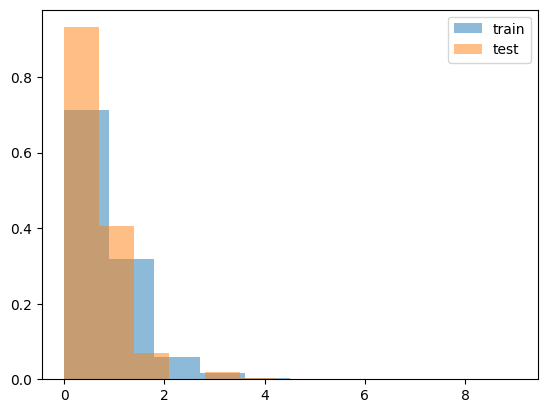

In [8]:
train_pred_df['pred_count'] = train_pred_df['yad_no'].apply(lambda d: len(d))
test_pred_df['pred_count'] = test_pred_df['yad_no'].apply(lambda d: len(d))

plt.hist(train_pred_df['pred_count'], label='train', alpha=0.5, density=True)
plt.hist(test_pred_df['pred_count'], label='test', alpha=0.5, density=True)
plt.legend()

In [14]:
idxs = train_pred_df['pred_count'] >= 1
idxs.sum()/len(train_pred_df)

0.35785492105937694

In [15]:
mapk(train_df[idxs]['yad_no'].to_list(), train_pred_df[idxs]['yad_no'].to_list(), k=10)

0.831981441329823